# Imports

Importare le varie librerie necessarie e le funzioni create

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [3]:
file_path='/Users/saravarone/Desktop/NECSTLAB/MDP/data_set.csv'
data=pd.read_csv(file_path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12823028 entries, 0 to 12823027
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   customer        int64  
 1   type            int64  
 2   timezoneOffset  int64  
 3   startTimestamp  object 
 4   endTimestamp    object 
 5   doubleValue     float64
 6   longValue       float64
 7   booleanValue    float64
 8   source          int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 880.5+ MB


In [4]:
data.head()

,customer,type,timezoneOffset,startTimestamp,endTimestamp,doubleValue,longValue,booleanValue,source
0,293476,3000,120,2020-08-29 11:29:15,2020-08-29 11:30:15,NaN,83.0,0.0,3
1,293476,3000,120,2020-08-29 11:30:15,2020-08-29 11:31:15,NaN,83.0,0.0,3
2,293476,3000,120,2020-08-29 11:31:15,2020-08-29 11:32:15,NaN,86.0,0.0,3
3,293476,3000,120,2020-08-29 11:32:15,2020-08-29 11:33:15,NaN,89.0,0.0,3
4,293476,3000,120,2020-08-29 11:33:15,2020-08-29 11:34:15,NaN,82.0,0.0,3


# EDA

In generale analizzare i dati presenti per capire come sono strutturati i dati per poter poi anche come dividerli al meglio nella fase di splitting pre creazione del modello in test, validation e training. Aiutati anche coi file forniti da dresda presenti in File_spiegazione.
Metadata:
- Costumer ID
- Plz= rough geographic position of the donor -> non credo ci interessi 
- Sesso
- Età
- BMI
- Kytp4: definisce il livello di urbanizzazione, è=2 per tutti -> non credo ci interessi 
- Tipo di dispositivo 

Per le serie temporali per capire come darle in input al modello analizzare nel dettaglio:
- durata temporale
- numero di sample 
- frequenza di acquisizione


I timestamp di inizio e fine sono forniti in formato "YYYY-MM-DD HH:MM:SS" con un offset (timezoneOffset). Vediamo che questo offset varia nel dataset, a volte è di 120 minuti a volte di 60, a volte 0. Noi vogliamo riportare tutti i timestamp in UTC così da uniformare nel tempo tutte le misurazioni. Se non normalizziamo infatti il modello vedrà eventi come simultanei, ma che in realtà non lo sono, e durate e frequenze saranno sfasate.

In [ ]:
# converto start/end in datetime (visto che sono stringhe "YYYY-MM-DD HH:MM:SS" -> formato "object")
data['startTimestamp'] = pd.to_datetime(data['startTimestamp'], errors='coerce')
data['endTimestamp']   = pd.to_datetime(data['endTimestamp'], errors='coerce')
data.dtypes #ora abbiamo convertito in datetime64[ns], che ci permette di fare operazioni sui timestamp

customer                   int64
type                       int64
timezoneOffset             int64
startTimestamp    datetime64[ns]
endTimestamp      datetime64[ns]
doubleValue              float64
longValue                float64
booleanValue             float64
source                     int64
type_name                 object
dtype: object

Ora voglio conoscere la natura di ciascun "type": sapere quali tipi di dato sono continui o quasi-continui (HR o SpO2), quali sono event-based, quali sono aggregati su finestre temporali, quali sono stati o categorie e con quale frequenza tipica vengono campionati. 

In [5]:

data.columns = data.columns.str.strip()
print(data.columns.tolist())

['customer', 'type', 'timezoneOffset', 'startTimestamp', 'endTimestamp', 'doubleValue', 'longValue', 'booleanValue', 'source']


In [6]:
typedf=pd.read_csv('/Users/saravarone/Desktop/NECSTLAB/MDP/MDP-Stress-/File_spiegazione/epoch_value_types.csv')

data['type_name']=data['type'].map(typedf.set_index('id')['code'])
data.head()

,customer,type,timezoneOffset,startTimestamp,endTimestamp,doubleValue,longValue,booleanValue,source,type_name
0,293476,3000,120,2020-08-29 11:29:15,2020-08-29 11:30:15,NaN,83.0,0.0,3,HeartRate
1,293476,3000,120,2020-08-29 11:30:15,2020-08-29 11:31:15,NaN,83.0,0.0,3,HeartRate
2,293476,3000,120,2020-08-29 11:31:15,2020-08-29 11:32:15,NaN,86.0,0.0,3,HeartRate
3,293476,3000,120,2020-08-29 11:32:15,2020-08-29 11:33:15,NaN,89.0,0.0,3,HeartRate
4,293476,3000,120,2020-08-29 11:33:15,2020-08-29 11:34:15,NaN,82.0,0.0,3,HeartRate


In [7]:
data['type_name'].unique() 

array(['HeartRate', 'Steps', 'SleepBinary'], dtype=object)

In [22]:
data['source'].unique()

array([3])

In [44]:
data['booleanValue'].unique()

array([ 0., nan,  1.])

Abbiamo solo dati relativi ad HeartRate, Steps e SleepBinary 

In [ ]:
#Per ogni costumer così otteniamo le serie temporali ordinate per tipo e dentro ciascun tipo ordinate nel tempo.
data=data.sort_values(['customer', 'type_name', 'startTimestamp']) 

#Ora vogliamo capire la frequenza di campionamento media delle serie temporali per ogni tipo di segnale
freq_info = (
    data.groupby(['customer','type_name'])['startTimestamp'] #prende per ogni pz e per ogni tipo di dato i timestamp di inizio
    .apply(lambda x: x.diff().dt.total_seconds().median())
    .groupby('type_name')
    .agg(['median','mean','count'])
    .rename(columns={'median':'median_dt_s','mean':'mean_dt_s','count':'n_customers'})
)

freq_info = freq_info.sort_values('median_dt_s')
freq_info.head(20)


,median_dt_s,mean_dt_s,n_customers
type_name,,,
HeartRate,60.0,60.0,10
SleepBinary,630.0,804.0,10
Steps,900.0,900.0,10


- HR: La frequenza media quindi è di 1 campione al minuto -> il wearable non dà i battiti beat-to-beat ma una media ogni 60s 
- SleepBinary: Mediana di 630s sono circa 10 minuti, media sono circa 13 minuti, quindi ogni 10-15 minuti viene registrato un nuovo valore (1 se dorme, 0 se sveglio) 
- Steps: Ogni 900s (15 min) i passi vengono aggregati e salvati 

Consiglio di verificare tra le prime cose che le serie temporali abbiano dei timestamp monotoni crescenti perchè in alcuni casi a causa di problemi di buffering dell'hardware la serie riporta dei valori di timestamp negativi oppure sfasati nel tempo casualmente (esempio in posizione 1 hai 10sec in posizione 2 9sec e in posizione 3 12sec). In questo caso a seconda del dato associato a quel timestamp si può decidere se eliminarli oppure riordinarli:

In [11]:
# per ogni paziente e tipo, controlla se i timestamp scendono invece di salire
check_monotonic = (
    data.groupby(['customer','type_name'])['startTimestamp']
    .apply(lambda x: (x.diff().dt.total_seconds() < 0).any())
)

# stampa i casi problematici
print(check_monotonic[check_monotonic]) #stampa una serie vuota, quindi non ci sono violonazioni di monotonia

Series([], Name: startTimestamp, dtype: bool)


In [12]:
# Calcolo la durata temporale di ogni serie temporale
durata = (
    data.groupby(['customer','type_name']) #raggruppo per paziente e tipo
    .agg(ts_start=('startTimestamp','min'), 
         ts_end=('startTimestamp','max'))
    .reset_index()
)

# durata in secondi
durata['duration_s'] = (durata['ts_end'] - durata['ts_start']).dt.total_seconds()

# durata in ore/giorni se più comodo
durata['duration_h'] = durata['duration_s'] / 3600
durata['duration_d'] = durata['duration_s'] / 86400

durata.head(31)

,customer,type_name,ts_start,ts_end,duration_s,duration_h,duration_d
0,101554,HeartRate,2020-06-25 00:00:00,2022-12-12 07:13:00,77785980.0,21607.216667,900.300694
1,101554,SleepBinary,2020-05-30 23:20:00,2022-12-12 05:48:00,79943280.0,22206.466667,925.269444
2,101554,Steps,2020-08-24 11:30:00,2022-12-12 07:01:28,72559888.0,20155.524444,839.813519
3,293476,HeartRate,2020-06-16 00:00:00,2022-12-13 19:48:15,78695295.0,21859.804167,910.825174
4,293476,SleepBinary,2020-04-12 03:06:00,2022-12-13 05:25:00,84248340.0,23402.316667,975.096528
5,293476,Steps,2020-06-16 06:45:00,2022-12-13 19:45:00,78670800.0,21853.000000,910.541667
6,419979,HeartRate,2020-06-23 00:00:00,2022-12-14 06:17:00,78128220.0,21702.283333,904.261806
7,419979,SleepBinary,2020-04-12 02:45:00,2022-12-14 04:38:00,84333180.0,23425.883333,976.078472
8,419979,Steps,2020-08-24 13:30:00,2022-12-14 06:15:00,72722700.0,20200.750000,841.697917
9,609619,HeartRate,2020-06-26 11:16:00,2022-12-14 18:15:00,77871540.0,21630.983333,901.290972


In [13]:
# Riassunto per tipo: mediana, media, min, max della durata delle serie temporali in giorni
durata_summary = (
    durata.groupby('type_name')['duration_d']
    .agg(['median','mean','min','max'])
    .rename(columns={
        'median':'median_duration_d',
        'mean':'mean_duration_d',
        'min':'min_duration_d',
        'max':'max_duration_d'
    })
)

# Aggiungo il nome del tipo leggendo da type_map (id -> code)
#durata_summary['type_name'] = durate_summary.index.map(type_map)

# Ordino dal più lungo al più corto
durata_summary = durata_summary.sort_values('median_duration_d', ascending=False)

durata_summary.head(20)  # stampa i primi 20

,median_duration_d,mean_duration_d,min_duration_d,max_duration_d
type_name,,,,
SleepBinary,976.561806,969.870694,925.269444,978.196528
HeartRate,905.365625,899.682899,850.677951,910.825174
Steps,843.333333,849.660519,839.813519,910.541667


Tutti i pazienti hanno >2 anni di dati per ogni segnale. 
Ora confronto anche le durate dei diversi segnali per lo stesso paziente -> creo una tabella con, per ogni costumer, la durata del segnale specifico

In [14]:
durata_pivot = durata.pivot(index='customer', columns='type_name', values='duration_d')

durata_pivot.head(10)

type_name,HeartRate,SleepBinary,Steps
customer,,,
101554,900.300694,925.269444,839.813519
293476,910.825174,975.096528,910.541667
419979,904.261806,976.078472,841.697917
609619,901.290972,976.079861,842.416667
710020,905.296528,977.043750,843.010417
736799,905.434722,977.265278,843.010417
899338,906.056250,977.254167,843.656250
954370,906.363889,958.261806,844.072917
1002502,906.321007,978.161111,844.041667


In generale i dati degli steps si interrompono prima (60/70 gg di differenza). 

Numero di samples per ogni serie temporale: 

In [15]:
# Numero di samples per ogni serie temporale (customer x tipo)
n_samples = (
    data.groupby(['customer','type_name'])
    .size()  # conta le righe per ciascun gruppo (quanti record ci sono per ciascun paziente)
    .reset_index(name='n_samples')
)

In [16]:
n_samples_summary = (
    n_samples.groupby('type_name')['n_samples']
    .agg(['median','mean','min','max'])
    .rename(columns={
        'median':'median_samples',
        'mean':'mean_samples',
        'min':'min_samples',
        'max':'max_samples'
    })
    .sort_values('median_samples', ascending=False)
)

n_samples_summary.head(20)

,median_samples,mean_samples,min_samples,max_samples
type_name,,,,
HeartRate,1239206.0,1219542.1,1146568,1272169
Steps,37444.5,37101.0,29624,42525
SleepBinary,27483.0,25659.7,13800,36176


In [50]:
# Frequenza per singola serie (mediana intervallo tra campioni)
sampling_per_series = (
    data.groupby(['customer','type_name'])['startTimestamp']
    .apply(lambda x: x.diff().dt.total_seconds().median())
    .reset_index(name='median_dt_s_series')
)

# Combino durata, numero di campioni e frequenza per ogni serie
summary = (
    durata[['customer','type_name','duration_d']]
    .merge(n_samples, on=['customer','type_name'])
    .merge(sampling_per_series, on=['customer','type_name'])
)

# Frequenza in campioni al minuto
summary['freq_samples_per_min_series'] = 60 / summary['median_dt_s_series']
# Ordina per customer e tipo
summary = summary.sort_values(['customer','type_name'])
summary = summary.sort_values(['type_name','customer'])
summary.head(30)

,customer,type_name,duration_d,n_samples,median_dt_s_series,freq_samples_per_min_series
0,101554,HeartRate,900.300694,1272169,60.0,1.000000
3,293476,HeartRate,910.825174,1240080,60.0,1.000000
6,419979,HeartRate,904.261806,1219556,60.0,1.000000
9,609619,HeartRate,901.290972,1241803,60.0,1.000000
12,710020,HeartRate,905.296528,1244980,60.0,1.000000
15,736799,HeartRate,905.434722,1146568,60.0,1.000000
18,899338,HeartRate,906.056250,1238332,60.0,1.000000
21,954370,HeartRate,906.363889,1161481,60.0,1.000000
24,1002502,HeartRate,906.321007,1253135,60.0,1.000000
27,1073627,HeartRate,850.677951,1177317,60.0,1.000000


In [51]:
#Frequenza in Hz per ogni singola serie 
summary['freq_Hz_series'] = 1 / summary['median_dt_s_series']

# Arrotondiamo per leggibilità
summary['freq_Hz_series'] = summary['freq_Hz_series'].round(4)
summary.head(30)

,customer,type_name,duration_d,n_samples,median_dt_s_series,freq_samples_per_min_series,freq_Hz_series
0,101554,HeartRate,900.300694,1272169,60.0,1.000000,0.0167
3,293476,HeartRate,910.825174,1240080,60.0,1.000000,0.0167
6,419979,HeartRate,904.261806,1219556,60.0,1.000000,0.0167
9,609619,HeartRate,901.290972,1241803,60.0,1.000000,0.0167
12,710020,HeartRate,905.296528,1244980,60.0,1.000000,0.0167
15,736799,HeartRate,905.434722,1146568,60.0,1.000000,0.0167
18,899338,HeartRate,906.056250,1238332,60.0,1.000000,0.0167
21,954370,HeartRate,906.363889,1161481,60.0,1.000000,0.0167
24,1002502,HeartRate,906.321007,1253135,60.0,1.000000,0.0167
27,1073627,HeartRate,850.677951,1177317,60.0,1.000000,0.0167


HeartRate ha frequenza costante in ogni serie (0.0167Hz o 1 sample/min), anche Steps ha frequenza costante di 0.0011Hz (o 0.067 sample/min), mentre SleepBinary ha frequenza più altalenante -> necessita di regridding/resampling. 

# Regridding e Resampling

Con regridding si intende riportare tutti i dati a una fequenza univoca, spesso può capitare che le serie abbiano una frequenza di campionamento simile ma non esattamente uguale, ad esempio ho tre serie una a 48Hz, una a 47,8Hz e una a 48,1Hz allora le riporto tutte a 48Hz.

Con resampling invece porti tutto a una stessa frequenza applicando un upsampling o downsampling. Per fare una cosa fatta bene la freqeunza di resampling andrebbe scelta senza eliminare le frequenze significative nel segnale preso in considerazione e che puoi vedere facendo una trasformata e/o dalla letteratura.

Caso di upsampling:
- introduzione di nuovi campioni. Esistono più tecniche più o meno complesse per farlo. 
- filtro passa basso per rimuovere le copie indesiderate

Caso di downsampling:
- filtro passa-basso con frequenza di cutoff < di metà della frequenza a cui vuoi resemplare
- diminuzione del numero di sample

N.B.: aiutati con grafici e ricorda che non è necessario siano tutte le serie alla stessa frequenza ma l'importnte è che lo siano le serie temporali dello stesso tipo (RR e HR possono averla differente ma due HR derivanti da dispositivi diversi no).

In [38]:
#Mi concentro su SleepBinary, in quanto Steps e HR hanno frequenza costante in ogni serie (0.0167Hz per HR, 0.0011Hz per Steps)
sleep=summary[summary['type_name']=='SleepBinary'].copy()
sleep_mean=sleep['median_dt_s_series'].mean()
sleep_mean_f=sleep['freq_Hz_series'].mean()
print(f'Frequenza media di SleepBinary: {sleep_mean_f} Hz o {sleep_mean} s')

Frequenza media di SleepBinary: 0.00148 Hz o 804.0 s


In [33]:
#Analisi dell'andamento delle frequenze di SleepBinary per ogni paziente
# statistiche globali
global_stats = sleep['median_dt_s_series'].describe(percentiles=[0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])
cv = sleep['median_dt_s_series'].std() / sleep['median_dt_s_series'].mean()

print("Statistiche per-customer median dt (s):")
print(global_stats)
print(f"Coefficient of variation (std/mean): {cv:.4f}")

# percentuali dentro intervalli intorno alla mediana globale
global_median = sleep['median_dt_s_series'].median()
for pct in [0.01,0.05,0.1,0.2]:  # 1%,5%,10%,20%
    lower = global_median * (1 - pct)
    upper = global_median * (1 + pct)
    frac = ((sleep['median_dt_s_series'] >= lower) & (sleep['median_dt_s_series'] <= upper)).mean()
    print(f"Percent within ±{int(pct*100)}% of global median ({global_median:.1f}s): {frac*100:.2f}%")

Statistiche per-customer median dt (s):
count      10.000000
mean      804.000000
std       388.020618
min       480.000000
1%        480.000000
5%        480.000000
10%       480.000000
25%       540.000000
50%       630.000000
75%      1080.000000
90%      1290.000000
95%      1425.000000
99%      1533.000000
max      1560.000000
Name: median_dt_s_series, dtype: float64
Coefficient of variation (std/mean): 0.4826
Percent within ±1% of global median (630.0s): 0.00%
Percent within ±5% of global median (630.0s): 20.00%
Percent within ±10% of global median (630.0s): 20.00%
Percent within ±20% of global median (630.0s): 50.00%


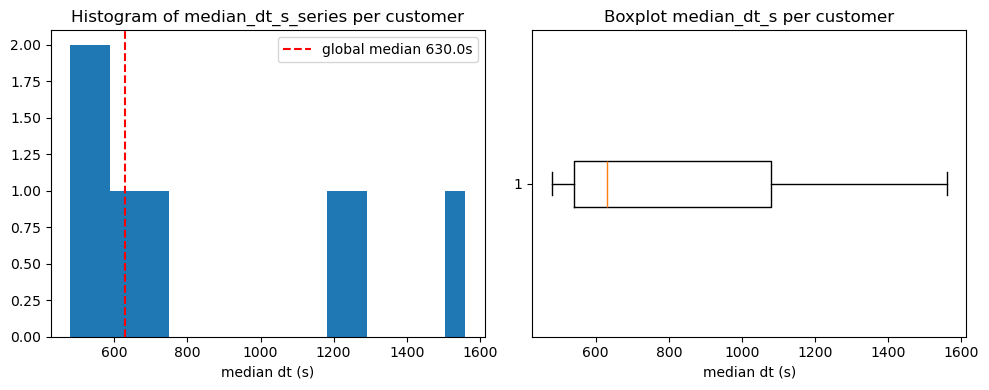

In [34]:
# istogramma + boxplot per vedere dispersione
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(sleep['median_dt_s_series'].dropna(), bins=20)
plt.axvline(global_median, color='red', linestyle='--', label=f'global median {global_median:.1f}s')
plt.title('Histogram of median_dt_s_series per customer')
plt.xlabel('median dt (s)'); plt.legend()

plt.subplot(1,2,2)
plt.boxplot(sleep['median_dt_s_series'].dropna(), vert=False)
plt.title('Boxplot median_dt_s per customer')
plt.xlabel('median dt (s)')

plt.tight_layout()
plt.show()

Variabilità molto alta (0.48) -> le serie non sono uniformi, le frequenze variano fortemente tra pazienti. Non è ottimale fare regridding. Ma serve davvero il resampling? Forse anche no, possiamo considerare semplicemente il totale di ore di sonno a notte.  

# Filtri
Individuazione di outliers e eliminazione di essi. Nel caso del dataset precedente era difficile definire se un valore fosse outlier o meno derivando da pazienti in terapia intensiva e comprendendo anche neonati.
Nel caso dei dati di Dresda dovrebbe essere più normale individuare outlier non fisiologici (es. un HR a 300bpm).


# Windowing

I dati per essere dati in pasto al modello vanno divisi in finestre uguali. La prassi è tenere un overlap del 50% per garantire che un evento contenuto in una finestra non venga perso da un troncamento netto.

N.B. in ogni passaggio effettua controlli e test, aiutandoti con print e grafici. I file non verrano mai caricati nella repository github ma consiglio di scrivere il codice in modo tale che modificando il path si salvino i vari file. Ho creato la cartella Preprocessed data da usare come spazio dove metterli.

# Diviosione in train, split, test

Ora che si hano delle finestre uniformi queste vanno divise in maniera sensata tra train, validation e test in modo tale che siano bilanciate.

Buon lavoro :)